Here we will demonstrate how to generate a stream in the regime of many subhalo impacts.
As usual, a GPU will provide signicant speedup, though this notebook is written for cpu usage.

If you would like to adapt this notebook for product runs on a gpu, change all usages of ``gen_stream_scan_with_pert`` to ``gen_stream_vmapped_with_pert``. The latter is optimized for gpu performancem, the former for cpu performance. This is due to difference between ``jax.lax.scan`` and ``jax.vmap``.

In [1]:
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Galactocentric


import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)

from streamsculptor import potential
from streamsculptor import JaxCoords as jc
import diffrax


from streamsculptor import JaxCoords as jc

import matplotlib as mpl

## Some plotting things (not necessary)
import scienceplots
plt.style.use('science')
mpl.rcParams['text.usetex'] = False ## We do not have LaTex on the HPC...



First we will define a gd-1 centric frame. These transformations are written in Jax so they can be differentiated.

In [2]:
@jax.jit
def icrs_to_gd1(ra_rad, dec_rad):
    """
    define a *differentiable* coordinate transfrom from ra and dec --> gd1 phi1, phi2
    Using the rotation matrix from Koposov+2010
    ra_rad: icrs ra [radians]
    dec_red: icrs dec [radians]
    """
    R = jnp.array(
        [
            [-0.4776303088, -0.1738432154, 0.8611897727],
            [0.510844589, -0.8524449229, 0.111245042],
            [0.7147776536, 0.4930681392, 0.4959603976],
        ]
    )


    icrs_vec = jnp.vstack([jnp.cos(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(dec_rad)]).T

    stream_frame_vec = jnp.einsum('ij,kj->ki',R,icrs_vec)
    
    phi1 = jnp.arctan2(stream_frame_vec[:,1],stream_frame_vec[:,0])*180/jnp.pi
    phi2 = jnp.arcsin(stream_frame_vec[:,2])*180/jnp.pi

    
    return phi1, phi2

@jax.jit
def get_phi12_from_stream(stream):
    """
    Differentiable helper function that takes us from simulated stream --> phi1, phi2
    """
    ra_s, dec_s, dist_ = jax.vmap(jc.simcart_to_icrs)(stream[:,:3])
    phi1_model, phi2_model = icrs_to_gd1(ra_s*jnp.pi/180, dec_s*jnp.pi/180)
    return phi1_model, phi2_model


Estimated progenitor location today in [kpc, kpc, kpc, kpc/Myr, kpc/Myr, kpc/Myr]
Estimated in a seperate file, but will provide a good starting point for this notebook. This file can be found in the data folder of the streamsculptor repository:
``data/GD1_prog/GD1_progenitor.npy``

In [3]:
prog_wtoday = jnp.load('../data/GD1_prog/GD1_progenitor.npy',allow_pickle=True).item()
pos = prog_wtoday.pos.xyz.to(u.kpc).value
vel = prog_wtoday.vel.d_xyz.to(u.kpc/u.Myr).value
prog_wtoday = jnp.hstack([pos,vel])


Setup the potential, stream age, dissolution time, stripping times. Then generate an unperturbed stream:

In [4]:
## Use Gala's MW potential
pot = potential.GalaMilkyWayPotential(units=usys)
## Define the age of the stream [Myr]
t_age = 2500.0
## Past time at which it dissolved [Myr]
t_dissolve = -300.0
## Get initial conditions
IC = pot.integrate_orbit(w0=prog_wtoday, t0=0.0, t1=-t_age,ts=jnp.array([-t_age])).ys[0]
## Define stripping times. ts[-1] is always the final integration time for gen_stream simulations
ts = jnp.hstack([jnp.linspace(-t_age,t_dissolve,2_000), jnp.array([0.0])])
## Generate unperturbed stream [l: lead, t: trail]
l ,t = pot.gen_stream_scan(prog_w0=IC,ts=ts,seed_num=532,Msat=1e4,atol=1e-6,rtol=1e-6,solver=diffrax.Dopri5())
stream = jnp.vstack([l,t])

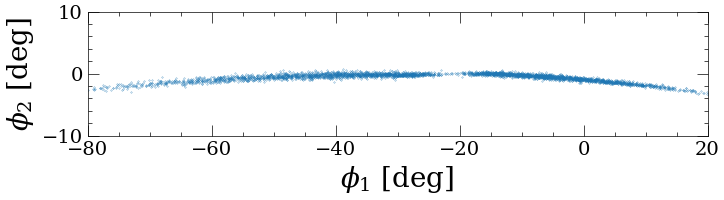

In [5]:
phi1_model, phi2_model = get_phi12_from_stream(stream)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(phi1_model, phi2_model,s=.05,color='tab:blue')

    
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-80,20)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

Goodbye, stream. 

Now we will introduce $N$ subhalos, using the ```ImpactGenerator```. The docstring of this function provides a decent overview, but the basic idea is that we randomly generate impacts by taking the average phase-space location of particles in $\phi_1$ bands (one such average gives us a "phase-space patch"), integrate back to an impact time, and randomly sample impact parameters, angles, and speeds in the frame of the phase-space patch we have just backwards integrated. 

We record the randomly sampled impact parameters, and a Cartesian representation of the subhalo fly-by, and output this information for use in setting up the potentials of the fly-bys. The bounds of the impact parameters (including time of impact, impact angles, distance of closest approach, etc.) can all be adjusted. Sensible defaults are provided.

Here's an example usage with 20 subhalos. Notice that for any case, the ``ImpactGenerator`` needs the unperturbed stream's $\phi_1$ coordinate to parametrize the impacts. This coordinate can be in physical units of (e.g.) length, deg, radian, etc. The only requirement is that it is some scalar parameter that is mappable to the arclength of the stream's track. 

In [6]:
from streamsculptor.GenerateImpactParams import ImpactGenerator
ImpactGen = ImpactGenerator(pot=pot, 
                            tobs=0.0, 
                            stream=stream, 
                            stream_phi1=phi1_model, 
                            phi1_bounds=[-80.,20.],
                            tImpactBounds=[-2500,0.0],
                            phi1window=.8, 
                            NumImpacts=20,
                            bImpact_bounds=[0,.1],
                            stripping_times=jnp.hstack([ts[:-1],ts[:-1]]),
                            prog_today=prog_wtoday,
                            seednum=10)

ImpactDict = ImpactGen.get_subhalo_ImpactParams()
print(ImpactDict.keys())

dict_keys(['CartesianImpactParams', 'ImpactFrameParams'])


Impact times are sampled from a pdf that is proportional to the stream's estimated length over time

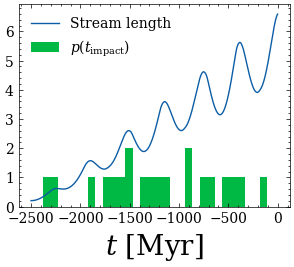

In [25]:
tImp = ImpactDict['ImpactFrameParams']['tImpact']
length_osc = ImpactGen.length_osc
plt.plot(length_osc['ts'],length_osc['length_func']/3,label='Stream length')
plt.hist(tImp,bins=30, label=r'$p(t_{\rm impact})$');
plt.xlabel(r'$t$ [Myr]',fontsize=20)

plt.legend()


In [26]:
ImpactDict['CartesianImpactParams'].shape

(20, 6)

In [27]:
ImpactDict['ImpactFrameParams'].keys()

dict_keys(['bImpact', 'perp_angle', 'phi1_samples', 'tImpact'])

In [29]:
# Impact parameters (b)
ImpactDict['ImpactFrameParams']['bImpact']

Array([0.04118562, 0.09401801, 0.01552384, 0.08869183, 0.05351032,
       0.06524352, 0.06476701, 0.0869972 , 0.03728792, 0.07826255,
       0.04843874, 0.04462604, 0.00320212, 0.08541246, 0.07178154,
       0.01595649, 0.0923549 , 0.08151711, 0.06760222, 0.02257853],      dtype=float64)

Now we will set up a function to generate the perturbed stream, given a 1d array of masses and scale-radii for the subhalos (length of these arrays == number of subhalos). We will jit compile the function. For production runs, this entire notebook can, in principle, be jit compiled. 

We will use the function ``gen_stream_scan_with_pert`` to generate the stream with perturbations.

In [14]:
from streamsculptor import gen_stream_vmapped_with_pert

In [50]:
@jax.jit
def gen_perturbed_stream(m, rs):
    pot_SH = potential.SubhaloLinePotential(m=m, 
                                            a=rs,
                                            subhalo_x0=ImpactDict['CartesianImpactParams'][:,:3],
                                            subhalo_v=ImpactDict['CartesianImpactParams'][:,3:],
                                            subhalo_t0=ImpactDict['ImpactFrameParams']['tImpact'],
                                            t_window=jnp.array([150.0]),
                                            units=usys)

    pot_lst = [pot, pot_SH]
    pot_total = potential.Potential_Combine(pot_lst,units=usys)

    IC = pot_total.integrate_orbit(w0=prog_wtoday, t0=0.0, t1=-t_age,ts=jnp.array([-t_age]),max_steps=10_000).ys[0]
    l ,t = gen_stream_vmapped_with_pert(pot_base=pot, pot_pert=pot_SH, prog_w0=IC, ts=ts, seed_num=532, Msat=1e4, max_steps=5_000,
                                        atol=1e-7,rtol=1e-7, solver=diffrax.Dopri5(), dtmin=0.05)
    stream = jnp.vstack([l,t])

    return stream



Run the simulation:

In [55]:
## 20 subhalos, masses of 5e6, scale radii of 0.05. This is all tuneable, but will make for 
## a very clearly perturbed stream
m = jnp.ones(20)*4e6
rs = jnp.ones(20)*0.05
perturbed_stream = gen_perturbed_stream(m, rs)

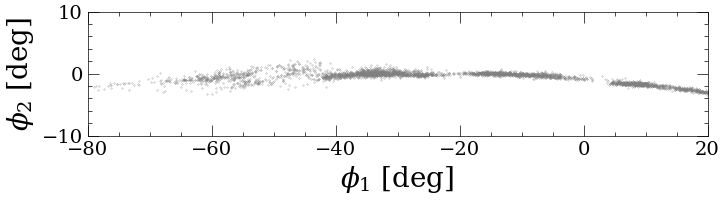

In [56]:
phi1_pert, phi2_pert = get_phi12_from_stream(perturbed_stream[:,:3])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)


ax.scatter(phi1_pert, phi2_pert,s=.05,color='grey')

    
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-80,20)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')